In [16]:
from __future__ import division, absolute_import

import sys
import os
import pickle
import numpy as np
import random
import gc
from math import ceil
import h5py
from glob import glob
from plotnine import *

from keras.callbacks import ModelCheckpoint, EarlyStopping, TerminateOnNaN
from keras import backend as K 
from keras.preprocessing import sequence
from keras.utils import np_utils
from keras.backend import manual_variable_initialization 
from keras.models import load_model, Model
from keras.layers import Dense, concatenate, Flatten, Conv1D, BatchNormalization, Input, Dropout
from keras.optimizers import Adam
from keras.preprocessing import sequence
from sklearn.metrics import f1_score

#root
absPath = '/home/angela3/imbalance_pcm_benchmark/'
sys.path.insert(0, absPath)

from src.model_functions import *

np.random.seed(8)
random.seed(8)

In [2]:
protein_type = "kinases"

In [3]:
list_paddings = ["post_padding", "pre_padding", "mid_padding", "ext_padding", "strf_padding",
                 "rnd_padding", "zoom_padding"]
# FOLD
fold = 0
n_epochs = 100
batch_size = 128

In [4]:
#Opening HDF5 with data
file_h5 = "".join((absPath, "data/", protein_type, "/no_resampling/compounds_activity.h5"))
f = h5py.File(file_h5, 'r')
group = '/activity'
table = "prot_comp"
#shuffling data indices
n_samples = len(f[group][table])
sample_indices = np.arange(0, n_samples)

In [5]:
#Loading maximum lengths of proteins and compounds
with open("".join((absPath, 'data/prot_max_len.pickle')), "rb") as input_file:
    max_len_prot = pickle.load(input_file)

#Defining protein dictionary    
instarget = Target("AAA")
prot_dict = instarget.predefining_dict()

# Loading the corresponding splitting list
file_list = "".join((absPath, "data/", protein_type, "/no_resampling/splitting_lists/splitting_", str(fold),"_list.pickle"))
with open(file_list, "rb") as input_file:
    splitting_list = pickle.load(input_file) 

In [6]:
learning_rate = 5e-4
decay_rate = learning_rate/n_epochs
adamm = Adam(lr=learning_rate, beta_1=0.1, beta_2=0.001, epsilon=1e-08, decay=decay_rate)

In [7]:
# define the model
# LEFT BLOCK (to analyse amino acid sequences)
input_seq = Input(shape=(max_len_prot, len(prot_dict)), dtype='float32')
conv_seq = Conv1D(filters=64, padding='same', strides=1, kernel_size=3, activation='relu')(input_seq)
dropout_1 = Dropout(0.4)(conv_seq)
flatten_seq = Flatten()(dropout_1)#(dense_seq)
dense_seq_2 = Dense(50)(flatten_seq)
dropout_2 = Dropout(0.4)(dense_seq_2)

#RIGHT BRANCH (to analyse fingerprints)
input_fps = Input(shape=(881,), dtype='float32')
dense_fps = Dense(50)(input_fps)
dropout_3 = Dropout(0.4)(dense_fps)
#bn_3 =  BatchNormalization()(dense_fps)#(dense_seq_2)#(conv_seq)


#MERGE BOTH BRANCHES
main_merged = concatenate([dropout_2, dropout_3],axis=1)#([dense_seq_2, dense_fps], axis=1)

main_dense = Dense(2, activation='softmax')(main_merged)

#build and compile model
model = Model(inputs=[input_seq, input_fps], outputs=[main_dense])
model.compile(loss='categorical_crossentropy', optimizer = adamm, metrics=['accuracy'])

model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 1499, 26)     0                                            
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 1499, 64)     5056        input_1[0][0]                    
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 1499, 64)     0           conv1d_1[0][0]                   
__________________________________________________________________________________________________
flatten_1 (Flatten)             (None, 95936)        0           dropout_1[0][0]                  
____________________________________________________________________________________________

In [8]:
# Data to train 
sample_size = 10000
train_perc = 0.8
val_perc = 1 - train_perc
np.random.seed(8)
training_indices = splitting_list[0]
training_size = int(sample_size*train_perc)
training_indices_subset = training_indices[:training_size]
training_indices_subset.sort()
validation_size = int(sample_size*val_perc)
val_indices_subset = training_indices[training_size:training_size+validation_size]
val_indices_subset.sort()

In [9]:
for type_padding_prot in list_paddings:
    #Defining generators
    train_generator = batch_generator_DL(batch_size, f, group, table, training_indices_subset, 
                                     max_len_prot, type_padding_prot=type_padding_prot)
    val_generator = batch_generator_DL(batch_size, f, group, table, val_indices_subset, 
                                     max_len_prot, type_padding_prot=type_padding_prot)
    name_padding_prot = type_padding_prot.split("_")[0]
    if not os.path.exists("".join((absPath, "data/padding_tuning/", name_padding_prot))):
        os.makedirs("".join((absPath, "data/padding_tuning/", name_padding_prot)))

    #if there are already files in the folder, it removes them
    r = glob("".join((absPath, "data/padding_tuning/", name_padding_prot, "/*.hdf5")))
    for i in r:
        os.remove(i)
   
    terminan = TerminateOnNaN()
    checkpoint_path = "".join((absPath, "data/padding_tuning/", name_padding_prot,
                           "/weights-improvement-{epoch:03d}-{val_accuracy:.4f}.hdf5"))
    mcheckpoint = ModelCheckpoint(checkpoint_path, monitor='val_accuracy', verbose=0, 
                                          save_best_only=True, save_weights_only=False)
    early_stopping = EarlyStopping(monitor='val_accuracy', min_delta=0.0001, patience=20, 
                                       restore_best_weights=True)
    callbacks_list = [terminan, mcheckpoint, early_stopping]

    his = model.fit_generator(generator=train_generator, validation_data=val_generator, 
                        steps_per_epoch=ceil(len(training_indices_subset)/batch_size),
                        validation_steps=ceil(len(val_indices_subset)/batch_size), 
                        epochs=n_epochs, callbacks=callbacks_list)

    K.clear_session()
    gc.collect()

Epoch 1/100
63/63 [==============================] - 11s 174ms/step - loss: 28.9084 - accuracy: 0.6049 - val_loss: 6.4351 - val_accuracy: 0.4292
Epoch 2/100
63/63 [==============================] - 5s 83ms/step - loss: 25.2266 - accuracy: 0.5767 - val_loss: 5.6964 - val_accuracy: 0.7229
Epoch 3/100
63/63 [==============================] - 5s 79ms/step - loss: 13.7507 - accuracy: 0.6110 - val_loss: 3.4128 - val_accuracy: 0.6008
Epoch 4/100
63/63 [==============================] - 5s 87ms/step - loss: 9.1871 - accuracy: 0.6453 - val_loss: 3.5009 - val_accuracy: 0.6668
Epoch 5/100
63/63 [==============================] - 5s 85ms/step - loss: 5.6179 - accuracy: 0.6501 - val_loss: 12.5188 - val_accuracy: 0.7679
Epoch 6/100
63/63 [==============================] - 5s 81ms/step - loss: 3.0224 - accuracy: 0.6660 - val_loss: 1.8658 - val_accuracy: 0.5758- loss: 3.8092 - accura - ETA: 2s - loss: 3.5594 - accura
Epoch 7/100
63/63 [==============================] - 5s 87ms/step - loss: 1.2808 - ac

63/63 [==============================] - 5s 84ms/step - loss: 0.7753 - accuracy: 0.6841 - val_loss: 1.1361 - val_accuracy: 0.7679
Epoch 18/100
63/63 [==============================] - 6s 88ms/step - loss: 0.7003 - accuracy: 0.7091 - val_loss: 0.9501 - val_accuracy: 0.7679- loss: 0.7056 
Epoch 19/100
63/63 [==============================] - 6s 88ms/step - loss: 0.6988 - accuracy: 0.7101 - val_loss: 0.7505 - val_accuracy: 0.7689l
Epoch 20/100
63/63 [==============================] - 5s 79ms/step - loss: 0.7631 - accuracy: 0.6921 - val_loss: 1.0843 - val_accuracy: 0.5033
Epoch 21/100
63/63 [==============================] - 6s 89ms/step - loss: 0.7038 - accuracy: 0.6936 - val_loss: 0.7907 - val_accuracy: 0.7169
Epoch 22/100
63/63 [==============================] - 6s 88ms/step - loss: 0.6877 - accuracy: 0.7258 - val_loss: 0.8852 - val_accuracy: 0.7689- loss: 0.6720 -  - ETA: 1s - loss: 0.6690 - accuracy - ETA: 1s - los
Epoch 23/100
63/63 [==============================] - 5s 87ms/step - l

/home/angela3/venv/lib/python3.6/site-packages/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.108876). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


63/63 [==============================] - 6s 87ms/step - loss: 0.7097 - accuracy: 0.7081 - val_loss: 0.9898 - val_accuracy: 0.76797089 - ac
Epoch 31/100
63/63 [==============================] - 6s 92ms/step - loss: 0.7324 - accuracy: 0.6974 - val_loss: 0.7949 - val_accuracy: 0.7069- loss: 0.6037 
Epoch 32/100
63/63 [==============================] - 5s 86ms/step - loss: 0.7293 - accuracy: 0.6979 - val_loss: 0.7880 - val_accuracy: 0.7179
Epoch 33/100
63/63 [==============================] - 6s 89ms/step - loss: 0.7505 - accuracy: 0.6977 - val_loss: 0.7184 - val_accuracy: 0.7284
Epoch 34/100
63/63 [==============================] - 5s 87ms/step - loss: 0.6673 - accuracy: 0.7166 - val_loss: 0.7627 - val_accuracy: 0.7144
Epoch 35/100
63/63 [==============================] - 6s 90ms/step - loss: 0.6738 - accuracy: 0.7110 - val_loss: 0.8560 - val_accuracy: 0.6738
Epoch 36/100
63/63 [==============================] - 6s 88ms/step - loss: 0.6652 - accuracy: 0.7085 - val_loss: 0.7905 - val_accur

63/63 [==============================] - 5s 84ms/step - loss: 0.6814 - accuracy: 0.7155 - val_loss: 0.9022 - val_accuracy: 0.7689
Epoch 45/100
63/63 [==============================] - 6s 91ms/step - loss: 0.6839 - accuracy: 0.7124 - val_loss: 0.7678 - val_accuracy: 0.7209
Epoch 46/100
63/63 [==============================] - 5s 85ms/step - loss: 0.7051 - accuracy: 0.7016 - val_loss: 0.7491 - val_accuracy: 0.7379
Epoch 47/100
63/63 [==============================] - 5s 86ms/step - loss: 0.7280 - accuracy: 0.7038 - val_loss: 0.8422 - val_accuracy: 0.7144
Epoch 48/100
63/63 [==============================] - 6s 89ms/step - loss: 0.6659 - accuracy: 0.7176 - val_loss: 1.4249 - val_accuracy: 0.4232
Epoch 49/100
63/63 [==============================] - 5s 87ms/step - loss: 0.7373 - accuracy: 0.6860 - val_loss: 0.8055 - val_accuracy: 0.7159
Epoch 50/100
63/63 [==============================] - 6s 90ms/step - loss: 0.6996 - accuracy: 0.6991 - val_loss: 0.7798 - val_accuracy: 0.7259
Epoch 51/100

/home/angela3/venv/lib/python3.6/site-packages/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.121136). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


63/63 [==============================] - 19s 302ms/step - loss: 1.0368 - accuracy: 0.6323 - val_loss: 0.6528 - val_accuracy: 0.7254
Epoch 3/100
 3/63 [>.............................] - ETA: 6s - loss: 0.7803 - accuracy: 0.6510

/home/angela3/venv/lib/python3.6/site-packages/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.129906). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


63/63 [==============================] - 20s 323ms/step - loss: 0.7942 - accuracy: 0.6629 - val_loss: 0.6307 - val_accuracy: 0.7499
Epoch 4/100
63/63 [==============================] - 19s 309ms/step - loss: 0.9075 - accuracy: 0.6559 - val_loss: 0.6413 - val_accuracy: 0.7509
Epoch 5/100
63/63 [==============================] - 19s 304ms/step - loss: 0.8160 - accuracy: 0.6841 - val_loss: 0.6529 - val_accuracy: 0.7644c - ETA: 3s - los
Epoch 6/100
63/63 [==============================] - 20s 310ms/step - loss: 0.7360 - accuracy: 0.7016 - val_loss: 0.6995 - val_accuracy: 0.7434
Epoch 7/100
63/63 [==============================] - 21s 328ms/step - loss: 0.7048 - accuracy: 0.6996 - val_loss: 0.8024 - val_accuracy: 0.6898
Epoch 8/100
63/63 [==============================] - 21s 338ms/step - loss: 0.7394 - accuracy: 0.6826 - val_loss: 0.8734 - val_accuracy: 0.6323
Epoch 9/100
63/63 [==============================] - 21s 329ms/step - loss: 0.6871 - accuracy: 0.7032 - val_loss: 0.9379 - val_accu

/home/angela3/venv/lib/python3.6/site-packages/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.171994). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/angela3/venv/lib/python3.6/site-packages/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.101121). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


63/63 [==============================] - 21s 329ms/step - loss: 0.6907 - accuracy: 0.6949 - val_loss: 0.7836 - val_accuracy: 0.7169
Epoch 12/100
63/63 [==============================] - 21s 333ms/step - loss: 0.6817 - accuracy: 0.7138 - val_loss: 1.0084 - val_accuracy: 0.5388
Epoch 13/100
 2/63 [..............................] - ETA: 9s - loss: 0.7164 - accuracy: 0.6133

/home/angela3/venv/lib/python3.6/site-packages/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.124773). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/angela3/venv/lib/python3.6/site-packages/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.104945). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


63/63 [==============================] - 21s 329ms/step - loss: 0.7944 - accuracy: 0.6877 - val_loss: 1.7587 - val_accuracy: 0.7679
Epoch 14/100
63/63 [==============================] - 20s 314ms/step - loss: 0.7735 - accuracy: 0.6951 - val_loss: 1.2312 - val_accuracy: 0.7679
Epoch 15/100
63/63 [==============================] - 21s 333ms/step - loss: 0.7062 - accuracy: 0.7007 - val_loss: 0.8740 - val_accuracy: 0.6843 loss: 0.6606 - ac - ETA: 6s - loss: 0.6542 - accuracy: 0.72 - E
Epoch 16/100
63/63 [==============================] - 21s 327ms/step - loss: 0.6470 - accuracy: 0.7218 - val_loss: 0.7688 - val_accuracy: 0.7164
Epoch 17/100
63/63 [==============================] - 21s 328ms/step - loss: 0.6185 - accuracy: 0.7195 - val_loss: 1.0895 - val_accuracy: 0.4627
Epoch 18/100
 2/63 [..............................] - ETA: 9s - loss: 0.8090 - accuracy: 0.5547

/home/angela3/venv/lib/python3.6/site-packages/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.169949). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/angela3/venv/lib/python3.6/site-packages/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.141066). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 4/63 [>.............................] - ETA: 9s - loss: 0.6426 - accuracy: 0.6797

/home/angela3/venv/lib/python3.6/site-packages/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.112183). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


63/63 [==============================] - 21s 327ms/step - loss: 0.6869 - accuracy: 0.7101 - val_loss: 0.7943 - val_accuracy: 0.7314A: 10s - loss: 0.592
Epoch 19/100
63/63 [==============================] - 20s 318ms/step - loss: 0.7574 - accuracy: 0.6964 - val_loss: 0.8442 - val_accuracy: 0.7694
Epoch 20/100
 2/63 [..............................] - ETA: 7s - loss: 1.1732 - accuracy: 0.5664

/home/angela3/venv/lib/python3.6/site-packages/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.140530). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/angela3/venv/lib/python3.6/site-packages/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.114388). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


63/63 [==============================] - 19s 298ms/step - loss: 0.7121 - accuracy: 0.7116 - val_loss: 0.7594 - val_accuracy: 0.7239
Epoch 21/100
 4/63 [>.............................] - ETA: 7s - loss: 0.5523 - accuracy: 0.7207

/home/angela3/venv/lib/python3.6/site-packages/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.115782). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


63/63 [==============================] - 21s 338ms/step - loss: 0.6455 - accuracy: 0.7165 - val_loss: 0.7863 - val_accuracy: 0.7694
Epoch 22/100
63/63 [==============================] - 20s 325ms/step - loss: 0.6312 - accuracy: 0.7325 - val_loss: 0.7273 - val_accuracy: 0.7264
Epoch 23/100
 3/63 [>.............................] - ETA: 9s - loss: 0.5909 - accuracy: 0.7083

/home/angela3/venv/lib/python3.6/site-packages/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.122362). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


63/63 [==============================] - 21s 327ms/step - loss: 0.6518 - accuracy: 0.7126 - val_loss: 0.7765 - val_accuracy: 0.7169- loss: 0.6397 - ac
Epoch 24/100
63/63 [==============================] - 21s 328ms/step - loss: 0.6817 - accuracy: 0.7035 - val_loss: 0.7440 - val_accuracy: 0.7579
Epoch 25/100
63/63 [==============================] - 20s 314ms/step - loss: 0.6128 - accuracy: 0.7251 - val_loss: 0.7575 - val_accuracy: 0.7159
Epoch 26/100
13/63 [=====>........................] - ETA: 20s - loss: 0.7994 - accuracy: 0.7188

/home/angela3/venv/lib/python3.6/site-packages/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.102669). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


63/63 [==============================] - 21s 330ms/step - loss: 0.7762 - accuracy: 0.7014 - val_loss: 0.7749 - val_accuracy: 0.7149
Epoch 27/100
14/63 [=====>........................] - ETA: 18s - loss: 0.6656 - accuracy: 0.6886

/home/angela3/venv/lib/python3.6/site-packages/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.111405). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


15/63 [======>.......................] - ETA: 19s - loss: 0.6814 - accuracy: 0.6865

/home/angela3/venv/lib/python3.6/site-packages/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.125504). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


63/63 [==============================] - 20s 325ms/step - loss: 0.6770 - accuracy: 0.7100 - val_loss: 2.6244 - val_accuracy: 0.7679
Epoch 28/100
19/63 [========>.....................] - ETA: 16s - loss: 0.8607 - accuracy: 0.6994

/home/angela3/venv/lib/python3.6/site-packages/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.102090). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


63/63 [==============================] - 20s 323ms/step - loss: 0.7672 - accuracy: 0.7013 - val_loss: 0.8303 - val_accuracy: 0.7034
Epoch 29/100
63/63 [==============================] - 21s 328ms/step - loss: 0.7396 - accuracy: 0.6979 - val_loss: 0.7800 - val_accuracy: 0.7109
Epoch 30/100
63/63 [==============================] - 21s 328ms/step - loss: 0.6882 - accuracy: 0.7229 - val_loss: 0.9062 - val_accuracy: 0.5598
Epoch 31/100
63/63 [==============================] - 20s 325ms/step - loss: 0.6702 - accuracy: 0.7091 - val_loss: 0.7327 - val_accuracy: 0.7304
Epoch 32/100
63/63 [==============================] - 20s 318ms/step - loss: 0.5956 - accuracy: 0.7340 - val_loss: 0.8865 - val_accuracy: 0.7689
Epoch 33/100
63/63 [==============================] - 21s 327ms/step - loss: 0.6971 - accuracy: 0.7091 - val_loss: 0.8333 - val_accuracy: 0.7039 accuracy: 
Epoch 34/100
63/63 [==============================] - 20s 322ms/step - loss: 0.7544 - accuracy: 0.6927 - val_loss: 0.8016 - val_accu

/home/angela3/venv/lib/python3.6/site-packages/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.135503). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


63/63 [==============================] - 20s 318ms/step - loss: 0.6496 - accuracy: 0.7235 - val_loss: 0.7825 - val_accuracy: 0.7254
Epoch 36/100
63/63 [==============================] - 21s 329ms/step - loss: 0.6616 - accuracy: 0.7188 - val_loss: 1.0250 - val_accuracy: 0.7679
Epoch 37/100
63/63 [==============================] - 20s 323ms/step - loss: 0.7175 - accuracy: 0.7078 - val_loss: 0.8168 - val_accuracy: 0.70399 - acc - ETA: 9s - loss: 0.6528 -
Epoch 38/100
63/63 [==============================] - 21s 326ms/step - loss: 0.6597 - accuracy: 0.7151 - val_loss: 0.7972 - val_accuracy: 0.7369
Epoch 39/100
63/63 [==============================] - 21s 327ms/step - loss: 0.7508 - accuracy: 0.6955 - val_loss: 0.8124 - val_accuracy: 0.7214
Epoch 1/100
63/63 [==============================] - 11s 182ms/step - loss: 0.8820 - accuracy: 0.6654 - val_loss: 0.7237 - val_accuracy: 0.2921
Epoch 2/100
63/63 [==============================] - 10s 164ms/step - loss: 0.7799 - accuracy: 0.6879 - val_lo

/home/angela3/venv/lib/python3.6/site-packages/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.111119). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


63/63 [==============================] - 11s 168ms/step - loss: 0.6826 - accuracy: 0.6825 - val_loss: 0.6153 - val_accuracy: 0.7679
Epoch 7/100
63/63 [==============================] - 11s 169ms/step - loss: 0.7801 - accuracy: 0.6631 - val_loss: 0.6283 - val_accuracy: 0.7659
Epoch 8/100
63/63 [==============================] - 11s 171ms/step - loss: 0.9245 - accuracy: 0.6490 - val_loss: 0.6292 - val_accuracy: 0.7624
Epoch 9/100
63/63 [==============================] - 11s 171ms/step - loss: 0.7635 - accuracy: 0.6794 - val_loss: 0.6177 - val_accuracy: 0.7674
Epoch 10/100
63/63 [==============================] - 10s 165ms/step - loss: 0.8253 - accuracy: 0.6841 - val_loss: 0.6319 - val_accuracy: 0.7444
Epoch 11/100
63/63 [==============================] - 11s 170ms/step - loss: 0.7168 - accuracy: 0.6833 - val_loss: 0.6705 - val_accuracy: 0.6218
Epoch 12/100
63/63 [==============================] - 10s 165ms/step - loss: 0.7017 - accuracy: 0.6850 - val_loss: 0.6344 - val_accuracy: 0.7579
E

/home/angela3/venv/lib/python3.6/site-packages/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.118713). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


63/63 [==============================] - 11s 167ms/step - loss: 0.7381 - accuracy: 0.6860 - val_loss: 0.6708 - val_accuracy: 0.6298
Epoch 20/100
63/63 [==============================] - 11s 170ms/step - loss: 0.8050 - accuracy: 0.6718 - val_loss: 0.6417 - val_accuracy: 0.7094
Epoch 21/100
63/63 [==============================] - 11s 173ms/step - loss: 0.7784 - accuracy: 0.6670 - val_loss: 0.6766 - val_accuracy: 0.5803
Epoch 22/100
63/63 [==============================] - 11s 168ms/step - loss: 0.8420 - accuracy: 0.6716 - val_loss: 0.6352 - val_accuracy: 0.7109
Epoch 1/100
63/63 [==============================] - 25s 402ms/step - loss: 0.7644 - accuracy: 0.6716 - val_loss: 1.0181 - val_accuracy: 0.7679
Epoch 2/100
63/63 [==============================] - 22s 343ms/step - loss: 0.6897 - accuracy: 0.7011 - val_loss: 0.7833 - val_accuracy: 0.6753
Epoch 3/100
63/63 [==============================] - 23s 372ms/step - loss: 0.6724 - accuracy: 0.7175 - val_loss: 0.7599 - val_accuracy: 0.7194
E

/home/angela3/venv/lib/python3.6/site-packages/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.128430). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


63/63 [==============================] - 23s 373ms/step - loss: 0.6672 - accuracy: 0.7121 - val_loss: 0.7652 - val_accuracy: 0.7359
Epoch 9/100
63/63 [==============================] - 23s 361ms/step - loss: 0.7251 - accuracy: 0.7049 - val_loss: 1.1200 - val_accuracy: 0.7679
Epoch 10/100
14/63 [=====>........................] - ETA: 21s - loss: 0.6858 - accuracy: 0.7316

/home/angela3/venv/lib/python3.6/site-packages/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.147251). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/angela3/venv/lib/python3.6/site-packages/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.104251). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


63/63 [==============================] - 23s 370ms/step - loss: 0.6680 - accuracy: 0.7160 - val_loss: 0.7255 - val_accuracy: 0.7634
Epoch 11/100
63/63 [==============================] - 23s 364ms/step - loss: 0.6471 - accuracy: 0.7109 - val_loss: 0.7459 - val_accuracy: 0.7209
Epoch 12/100
 3/63 [>.............................] - ETA: 9s - loss: 0.5653 - accuracy: 0.7266 

/home/angela3/venv/lib/python3.6/site-packages/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.162646). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/angela3/venv/lib/python3.6/site-packages/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.110691). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


63/63 [==============================] - 23s 368ms/step - loss: 0.6773 - accuracy: 0.7103 - val_loss: 0.7746 - val_accuracy: 0.7454
Epoch 13/100
63/63 [==============================] - 23s 368ms/step - loss: 0.6738 - accuracy: 0.7146 - val_loss: 0.8996 - val_accuracy: 0.6653
Epoch 14/100
 5/63 [=>............................] - ETA: 6s - loss: 0.6676 - accuracy: 0.7109

/home/angela3/venv/lib/python3.6/site-packages/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.110448). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


63/63 [==============================] - 23s 370ms/step - loss: 0.6716 - accuracy: 0.7139 - val_loss: 0.7744 - val_accuracy: 0.7199
Epoch 15/100
63/63 [==============================] - 23s 364ms/step - loss: 0.6791 - accuracy: 0.7185 - val_loss: 0.8647 - val_accuracy: 0.6583
Epoch 16/100
 2/63 [..............................] - ETA: 8s - loss: 0.7646 - accuracy: 0.6484

/home/angela3/venv/lib/python3.6/site-packages/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.120983). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 6/63 [=>............................] - ETA: 8s - loss: 0.6783 - accuracy: 0.7044

/home/angela3/venv/lib/python3.6/site-packages/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.100044). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


13/63 [=====>........................] - ETA: 20s - loss: 0.6976 - accuracy: 0.6875

/home/angela3/venv/lib/python3.6/site-packages/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.104253). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


17/63 [=======>......................] - ETA: 20s - loss: 0.6764 - accuracy: 0.6893

/home/angela3/venv/lib/python3.6/site-packages/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.103917). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


63/63 [==============================] - 23s 369ms/step - loss: 0.6673 - accuracy: 0.7079 - val_loss: 0.7425 - val_accuracy: 0.7759
Epoch 17/100
 3/63 [>.............................] - ETA: 7s - loss: 0.6366 - accuracy: 0.7708

/home/angela3/venv/lib/python3.6/site-packages/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.105766). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


63/63 [==============================] - 22s 352ms/step - loss: 0.6834 - accuracy: 0.7155 - val_loss: 0.7473 - val_accuracy: 0.7219
Epoch 18/100
 4/63 [>.............................] - ETA: 7s - loss: 0.5602 - accuracy: 0.7559

/home/angela3/venv/lib/python3.6/site-packages/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.208330). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/angela3/venv/lib/python3.6/site-packages/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.107396). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


63/63 [==============================] - 24s 374ms/step - loss: 0.6717 - accuracy: 0.7189 - val_loss: 0.8798 - val_accuracy: 0.7689
Epoch 19/100
63/63 [==============================] - 22s 357ms/step - loss: 0.7315 - accuracy: 0.7050 - val_loss: 0.8076 - val_accuracy: 0.7184
Epoch 20/100
 3/63 [>.............................] - ETA: 6s - loss: 0.5859 - accuracy: 0.7161

/home/angela3/venv/lib/python3.6/site-packages/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.119726). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


63/63 [==============================] - 23s 361ms/step - loss: 0.6200 - accuracy: 0.7309 - val_loss: 1.1967 - val_accuracy: 0.4192
Epoch 21/100
63/63 [==============================] - 23s 370ms/step - loss: 0.7327 - accuracy: 0.6949 - val_loss: 1.1336 - val_accuracy: 0.5318
Epoch 22/100
63/63 [==============================] - 23s 361ms/step - loss: 0.6481 - accuracy: 0.7224 - val_loss: 0.7275 - val_accuracy: 0.7214
Epoch 23/100
63/63 [==============================] - 23s 370ms/step - loss: 0.6664 - accuracy: 0.7194 - val_loss: 0.8522 - val_accuracy: 0.6848
Epoch 24/100
63/63 [==============================] - 23s 363ms/step - loss: 0.7644 - accuracy: 0.7063 - val_loss: 1.3251 - val_accuracy: 0.4312
Epoch 25/100
 4/63 [>.............................] - ETA: 8s - loss: 0.8842 - accuracy: 0.6211

/home/angela3/venv/lib/python3.6/site-packages/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.131076). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/angela3/venv/lib/python3.6/site-packages/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.103495). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


63/63 [==============================] - 24s 377ms/step - loss: 0.7370 - accuracy: 0.6965 - val_loss: 0.7849 - val_accuracy: 0.7149
Epoch 26/100
63/63 [==============================] - 23s 373ms/step - loss: 0.7166 - accuracy: 0.7024 - val_loss: 0.8690 - val_accuracy: 0.6878
Epoch 27/100
63/63 [==============================] - 22s 349ms/step - loss: 0.6887 - accuracy: 0.7100 - val_loss: 2.5296 - val_accuracy: 0.7679
Epoch 28/100
63/63 [==============================] - 24s 374ms/step - loss: 0.7609 - accuracy: 0.6967 - val_loss: 0.7981 - val_accuracy: 0.7744
Epoch 29/100
63/63 [==============================] - 23s 357ms/step - loss: 0.6418 - accuracy: 0.7151 - val_loss: 0.7531 - val_accuracy: 0.7349
Epoch 30/100
63/63 [==============================] - 24s 375ms/step - loss: 0.6374 - accuracy: 0.7161 - val_loss: 0.7594 - val_accuracy: 0.7339
Epoch 31/100
 2/63 [..............................] - ETA: 8s - loss: 0.5956 - accuracy: 0.7266

/home/angela3/venv/lib/python3.6/site-packages/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.107893). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/angela3/venv/lib/python3.6/site-packages/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.116982). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


63/63 [==============================] - 23s 367ms/step - loss: 0.7501 - accuracy: 0.6777 - val_loss: 0.8170 - val_accuracy: 0.7744
Epoch 32/100
 4/63 [>.............................] - ETA: 6s - loss: 0.5683 - accuracy: 0.7656

/home/angela3/venv/lib/python3.6/site-packages/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.108284). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


63/63 [==============================] - 23s 372ms/step - loss: 0.6995 - accuracy: 0.7191 - val_loss: 0.8184 - val_accuracy: 0.7749
Epoch 33/100
 3/63 [>.............................] - ETA: 6s - loss: 0.6398 - accuracy: 0.7214

/home/angela3/venv/lib/python3.6/site-packages/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.110324). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 8/63 [==>...........................] - ETA: 15s - loss: 0.6849 - accuracy: 0.7402

/home/angela3/venv/lib/python3.6/site-packages/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.100138). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 9/63 [===>..........................] - ETA: 17s - loss: 0.7040 - accuracy: 0.7266

/home/angela3/venv/lib/python3.6/site-packages/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.105180). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


63/63 [==============================] - 23s 372ms/step - loss: 0.7145 - accuracy: 0.7003 - val_loss: 0.8340 - val_accuracy: 0.7104
Epoch 34/100
 4/63 [>.............................] - ETA: 7s - loss: 0.7741 - accuracy: 0.6172

/home/angela3/venv/lib/python3.6/site-packages/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.101445). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 7/63 [==>...........................] - ETA: 10s - loss: 0.7162 - accuracy: 0.6786

/home/angela3/venv/lib/python3.6/site-packages/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.119218). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


63/63 [==============================] - 23s 362ms/step - loss: 0.7717 - accuracy: 0.6935 - val_loss: 0.7429 - val_accuracy: 0.7589
Epoch 35/100
 4/63 [>.............................] - ETA: 8s - loss: 0.6437 - accuracy: 0.7168

/home/angela3/venv/lib/python3.6/site-packages/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.109058). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


63/63 [==============================] - 23s 367ms/step - loss: 0.6963 - accuracy: 0.7197 - val_loss: 0.7757 - val_accuracy: 0.7319
Epoch 36/100
63/63 [==============================] - 23s 367ms/step - loss: 0.7090 - accuracy: 0.7070 - val_loss: 0.7851 - val_accuracy: 0.7299


In [12]:
# Getting y_true
splitting_list[2].sort()
y_true = f[group][table][splitting_list[2]]["label"]

# Looping to get all the results
df_total = pd.DataFrame(columns=["f1", "pad_prot", "pad_comp"])
idx = 0
for type_padding_prot in list_paddings:
    print("Type padding protein", type_padding_prot)
    dict_prot = {}
    #Defining generators
    test_generator = batch_generator_DL(batch_size, f, group, table, splitting_list[2], 
                                     max_len_prot, type_padding_prot=type_padding_prot)
    name_padding_prot = type_padding_prot.split("_")[0]
    model_path = "".join((absPath, "data/padding_tuning/",  name_padding_prot, "/"))
    r = glob("".join((model_path, "*.hdf5")))
    model = load_model(r[0])
    predprob = model.predict_generator(test_generator, steps=round(len(splitting_list[2])/batch_size))
    y_test = predprob.argmax(axis=-1)   
    f1 = f1_score(y_true=y_true, y_pred=y_test)

    df_total.loc[idx,"f1"] = round(f1,3)
    df_total.loc[idx, "pad_prot"] = name_padding_prot
        
    idx = idx+1
                             
    K.clear_session()
    gc.collect()

Type padding protein post_padding
Type padding protein pre_padding
Type padding protein mid_padding
Type padding protein ext_padding
Type padding protein strf_padding
Type padding protein rnd_padding
Type padding protein zoom_padding


In [23]:
df_total["f1"] = pd.to_numeric(df_total["f1"])

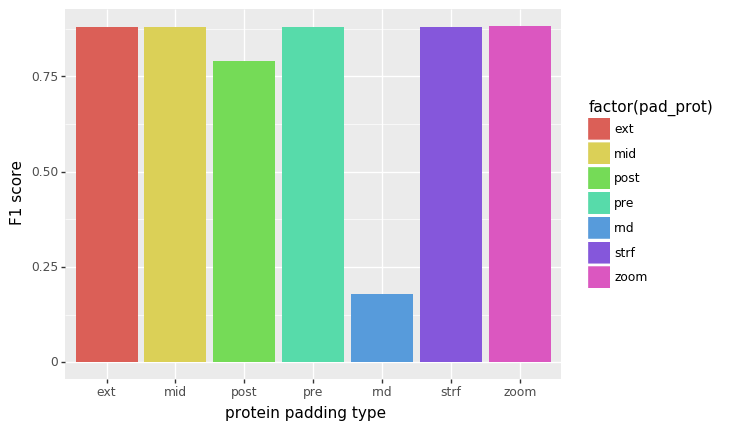

<ggplot: (8780033071126)>

In [24]:
#Plotting result     
p = (ggplot(df_total, aes(x="pad_prot", y="f1", fill="factor(pad_prot)")) 
 + geom_bar(position="dodge", stat="identity")
+ xlab("protein padding type")
#+ scale_fill_discrete(name = "compound padding type")
+ ylab("F1 score")
) 

p

In [25]:
ggsave(plot=p, filename="".join((absPath, "data/padding_tuning/padding_tuning_result.pdf")), dpi=1000)

/home/angela3/venv/lib/python3.6/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 6.4 x 4.8 in image.
  from_inches(height, units), units), PlotnineWarning)
/home/angela3/venv/lib/python3.6/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: /home/angela3/imbalance_pcm_benchmark/data/padding_tuning/padding_tuning_result.pdf
  warn('Filename: {}'.format(filename), PlotnineWarning)
